# Linear Model + non linear activation function

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
data_folder = './../Data/cifar/cifar-10/'
Xtr = np.load(data_folder + 'Xtr.npy')
ytr = np.load(data_folder + 'ytr.npy')
Xte = np.load(data_folder + 'Xte.npy')
yte = np.load(data_folder + 'yte.npy')
labels = read_dictionary = np.load(data_folder + 'labels_dict.npy',allow_pickle='TRUE').item()
true_shape = (32, 32, 3)
# transpose to (1,2,0)
n = int(Xtr.shape[0]*0.8)
Xtr , Xval = Xtr[:n] , Xtr[n:]
ytr , yval = ytr[:n] , ytr[n:]
Xtr.shape , ytr.shape , Xval.shape , yval.shape , Xte.shape , yte.shape , len(labels) , labels

((40000, 3072),
 (40000,),
 (10000, 3072),
 (10000,),
 (10000, 3072),
 (10000,),
 10,
 {0: 'jetliner',
  1: 'shooting',
  2: 'gamecock',
  3: 'domestic',
  4: 'wapiti',
  5: 'toy',
  6: 'green',
  7: 'lippizan',
  8: 'hydrofoil',
  9: 'dustcart'})

In [3]:
Xtr = torch.tensor(Xtr , dtype = torch.float32)
ytr = torch.tensor(ytr , dtype = torch.float32)
Xval = torch.tensor(Xval , dtype = torch.float32)
yval = torch.tensor(yval , dtype = torch.float32)
Xte = torch.tensor(Xte , dtype = torch.float32)
yte = torch.tensor(yte , dtype = torch.float32)

ytr_enc = torch.zeros(ytr.shape[0] , len(labels)) 
yval_enc = torch.zeros(yval.shape[0] , len(labels))
yte_enc = torch.zeros(yte.shape[0] , len(labels))
ytr_enc[torch.arange(ytr.shape[0]) , ytr.long()] = 1
yval_enc[torch.arange(yval.shape[0]) , yval.long()] = 1
yte_enc[torch.arange(yte.shape[0]) , yte.long()] = 1

## 2 layer MLP
2 layer neural network with linear model and non linear activation function.

flow :

3072 -> 100 -> 10 

#### Activations : relu

In [4]:
def relu(x):
    return x * (x > 0) 

def d_relu(x):
    return 1. * (x > 0) 

In [27]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis = 1).reshape(-1,1) 

def d_softmax(x):
    return softmax(x) * (1 - softmax(x))

### Data preprocessing

In [8]:
## Subtract mean image
Xtr -= torch.mean(Xtr, dim = 1, keepdim = True)
Xtr.shape

torch.Size([40000, 3072])

### Batch Sampler

In [15]:
class dataset():
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.i = 0
        self.mask = torch.arange(self.n)
    
    def next_batch(self, batch_size):
        if self.i + batch_size > self.n:
            self.reset()
        X_batch = self.X[self.mask][self.i : self.i + batch_size]
        y_batch = self.y[self.mask][self.i : self.i + batch_size]
        self.i += batch_size
        return X_batch, y_batch 

    def reset(self):
        self.i = 0
        self.mask = torch.randperm(self.n)

In [32]:
train = dataset(Xtr, ytr_enc)
val = dataset(Xval, yval_enc)

### Weight init (Xaiver init & Kaiming init)

In [104]:
h1_neurons = 100


W1 = torch.rand(Xtr.shape[1], h1_neurons) * np.sqrt(2.0 / Xtr.shape[1]) * 0.01 # Kaiming He initialization
b1 = torch.zeros(h1_neurons)

W2 = torch.rand(h1_neurons, len(labels)) * np.sqrt(2.0 / h1_neurons) * 0.01 # Kaiming He initialization 
b2 = torch.zeros(len(labels))

In [105]:
parameters = [W1, b1, W2, b2] 
updates = [torch.zeros_like(p) for p in parameters] 

def grad_zero(updates):
    for u in updates:
        u.zero_()
        
grad_zero(updates)
updates[0][:5,:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [106]:
def forward(X, W1, b1, W2, b2):
    h1 = X @ W1 + b1
    a1 = relu(h1)
    h2 = a1 @ W2 + b2
    a2 = softmax(h2)
    return h1, a1, h2, a2

Xbtr, ybtr = train.next_batch(10)
h1, a1, h2, a2 = forward( Xbtr,*parameters)
a1[:5,:5] , a2[:5,:5]

(tensor([[2.3066e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, 2.0936e-01],
         [-0.0000e+00, 1.4177e-01, 4.6027e-02, 2.8563e-04, 9.1992e-02],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00, 1.1815e-01, -0.0000e+00],
         [1.4938e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00, 2.5517e-01],
         [2.5581e-02, -0.0000e+00, 7.9031e-02, 4.3658e-01, -0.0000e+00]]),
 tensor([[0.1000, 0.1000, 0.0999, 0.1001, 0.0999],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.1001, 0.1000, 0.1000, 0.1001, 0.0999],
         [0.1001, 0.1000, 0.0999, 0.1001, 0.1000]]))

In [107]:
def BatchNorm(h, gamma = 1, beta = 0, eps = 1e-5):
    # print(h.shape)
    mu_bn = torch.mean(h,axis = 0)
    var_bn = torch.var(h,axis = 0)
    # print(mu_bn.shape , var_bn.shape)
    h_hat = h - mu_bn / torch.sqrt(var_bn + eps)
    # print(h_hat.shape)
    y_k = gamma * h_hat + beta
    return y_k


def forward(X, W1, b1, W2, b2, gamma = 1, beta = 0):
    h1 = X @ W1 + b1
    bn1 = BatchNorm(h1, gamma, beta)
    a1 = relu(bn1)
    h2 = a1 @ W2 + b2
    bn2 = BatchNorm(h2, gamma, beta)
    a2 = softmax(bn2)
    return h1, a1,  h2, a2

Xbtr, ybtr = train.next_batch(10)
h1, a1,  h2, a2 = forward( Xbtr,*parameters)
a1[:5,:5] , a2[:5,:5]

(tensor([[0.1237, -0.0000, -0.0000, -0.0000, -0.0000],
         [0.0086, -0.0000, -0.0000, -0.0000, -0.0000],
         [0.2934, -0.0000, -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
         [0.1773, 0.0556, -0.0000, -0.0000, -0.0000]]),
 tensor([[0.0973, 0.0995, 0.0768, 0.0917, 0.1427],
         [0.0973, 0.0995, 0.0768, 0.0917, 0.1429],
         [0.0973, 0.0995, 0.0769, 0.0916, 0.1429],
         [0.0974, 0.0995, 0.0767, 0.0916, 0.1429],
         [0.0973, 0.0996, 0.0768, 0.0917, 0.1430]]))

In [108]:
def loss(y, y_hat):
    return -torch.sum(y * torch.log(y_hat))

def accuracy(y, y_hat):
    return torch.sum(y.argmax(dim = 1) == y_hat.argmax(dim = 1)) / y.shape[0]

lss = loss(ybtr, a2)
acc = accuracy(ybtr, a2)
lss , acc

(tensor(23.0551), tensor(0.1000))

In [109]:
def backward(X, y, h1, a1, h2, a2, W1, b1, W2, b2):
    m = X.shape[0]
    dy = a2 - y
    dW2 = a1.T @ dy
    db2 = torch.sum(dy, axis = 0)
    da1 = dy @ W2.T
    dh1 = da1 * d_relu(a1)
    dW1 = X.T @ dh1
    db1 = torch.sum(dh1, axis = 0)
    return dW1, db1, dW2, db2

dW1, db1, dW2, db2 = backward(Xbtr, ybtr, h1, a1, h2, a2, *parameters) 
dW1.shape, db1.shape, dW2.shape, db2.shape

(torch.Size([3072, 100]),
 torch.Size([100]),
 torch.Size([100, 10]),
 torch.Size([10]))

Iteration       0 Loss 2218.9838867
Iteration      10 Loss 2223.4924316
Iteration      20 Loss 2223.1689453
Iteration      30 Loss 2200.8801270
Iteration      40 Loss 2176.1425781
Iteration      50 Loss 2176.8764648
Iteration      60 Loss 2187.6982422
Iteration      70 Loss 2170.9963379
Iteration      80 Loss 2153.6015625
Iteration      90 Loss 2160.8793945


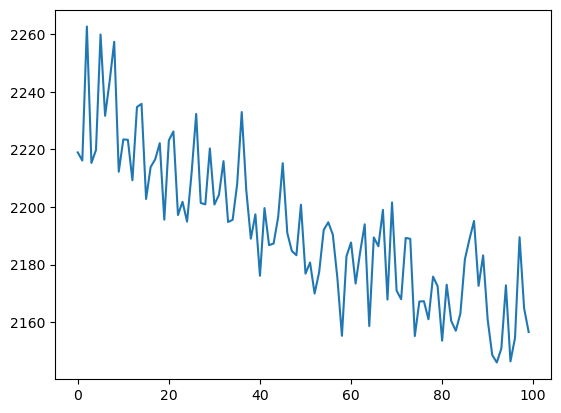

In [112]:
class adam:
    
    def __init__(self, parameters, lr = 0.001, b1 = 0.9, b2 = 0.999, eps = 1e-8):
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.eps = eps
        self.parameters = parameters
        self.m_k = [0 for _ in parameters]
        self.u_k = [0 for _ in parameters]
    
    def update(self, grads):
        for i in range(len(self.parameters)):
            self.m_k[i] = self.b1 * self.m_k[i] + (1 - self.b1) * grads[i]
            self.u_k[i] = self.b2 * self.u_k[i] + (1 - self.b2) * grads[i]**2
            m_k_hat = self.m_k[i] / (1 - self.b1)
            u_k_hat = self.u_k[i] / (1 - self.b2)
            self.parameters[i] -= self.lr * m_k_hat / (torch.sqrt(u_k_hat) + self.eps)
    
    def optimize(self, forward, backward, loss, train , max_iters = 10): 
        train_losses = []
        
        for i in range(max_iters):
            X , y = train.next_batch(1000)
            h1, a1, h2, a2 = forward(X, *self.parameters)
            grads = backward(X, y, h1, a1, h2, a2, *self.parameters)
            lss = loss(y, a2)
            self.update(grads)
            train_losses.append(lss)
            if i % (max_iters//10) == 0:
                print(f'Iteration {i:7} Loss {lss:.7f}')
        return train_losses

adam_opt = adam(parameters, lr = 1e-6)
lss_d = adam_opt.optimize(forward, backward, loss, train, max_iters = 100)

plt.plot(lss_d)

Iteration       0 Loss 2307.2929688
Iteration    1000 Loss 2048.8305664
Iteration    2000 Loss 1935.7929688
Iteration    3000 Loss 1906.7773438
Iteration    4000 Loss 1863.6617432
Iteration    5000 Loss 1767.7055664
Iteration    6000 Loss 1780.6060791
Iteration    7000 Loss 1800.4802246
Iteration    8000 Loss 1743.0712891
Iteration    9000 Loss 1692.9034424


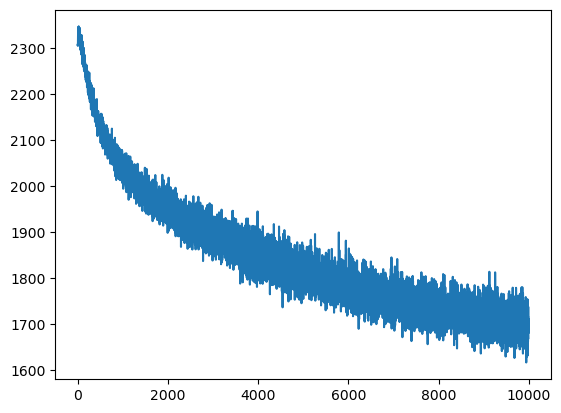

In [113]:
h1_neurons = 100


W1 = torch.rand(Xtr.shape[1], h1_neurons) * np.sqrt(2.0 / Xtr.shape[1]) * 0.01 # Kaiming He initialization
b1 = torch.zeros(h1_neurons)

W2 = torch.rand(h1_neurons, len(labels)) * np.sqrt(2.0 / h1_neurons) * 0.01 # Kaiming He initialization 
b2 = torch.zeros(len(labels))

parameters = [W1, b1, W2, b2] 

adam_opt = adam(parameters, lr = 1e-6)
lss_d = adam_opt.optimize(forward, backward, loss, train, max_iters = 10000)

plt.plot(lss_d)

In [114]:
y_pred = forward(Xte, *adam_opt.parameters)
lsss = loss(yte_enc, y_pred[-1])
lsss
acc = accuracy(yte_enc, y_pred[-1])
acc

tensor(29707.9434)

tensor(0.2223)

## Using Pytorch

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [5]:
data_folder = './../Data/cifar/cifar-10/'
Xtr = np.load(data_folder + 'Xtr.npy')
ytr = np.load(data_folder + 'ytr.npy')
Xte = np.load(data_folder + 'Xte.npy')
yte = np.load(data_folder + 'yte.npy')
n = int(Xtr.shape[0] * 0.8)
Xtr, Xval = Xtr[:n], Xtr[n:]
ytr, yval = ytr[:n], ytr[n:]

In [6]:
class CIFARDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = CIFARDataset(Xtr, ytr)
val_dataset = CIFARDataset(Xval, yval)
test_dataset = CIFARDataset(Xte, yte)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

dummy = next(iter(train_loader))
dummy[0].shape, dummy[1].shape

(torch.Size([64, 3072]), torch.Size([64]))

In [7]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size , bias = True)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = FCNet(Xtr.shape[1], 128, len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6)

In [8]:
torch.log(criterion(model(dummy[0]), dummy[1]))

tensor(3.8436, grad_fn=<LogBackward0>)

In [9]:
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1/10, Train Loss: 15.6027, Val Loss: 9.3223
Epoch 2/10, Train Loss: 7.9254, Val Loss: 6.9746
Epoch 3/10, Train Loss: 6.5402, Val Loss: 6.1132
Epoch 4/10, Train Loss: 5.7450, Val Loss: 5.4415
Epoch 5/10, Train Loss: 5.1455, Val Loss: 4.8949
Epoch 6/10, Train Loss: 4.6994, Val Loss: 4.5555
Epoch 7/10, Train Loss: 4.3912, Val Loss: 4.2814
Epoch 8/10, Train Loss: 4.1086, Val Loss: 4.0219
Epoch 9/10, Train Loss: 3.8467, Val Loss: 3.8027
Epoch 10/10, Train Loss: 3.6451, Val Loss: 3.6208


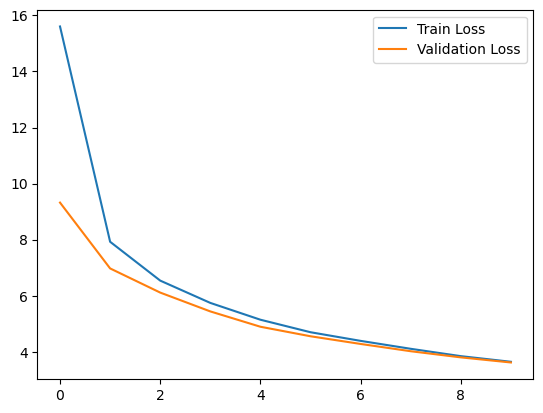

In [10]:
plt.plot(train_losses, label='Train Loss')  
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [11]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 21.11%


In [12]:
epochs = 10
for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1/10, Train Loss: 3.4744, Val Loss: 3.4664
Epoch 2/10, Train Loss: 3.3222, Val Loss: 3.3111
Epoch 3/10, Train Loss: 3.0544, Val Loss: 2.7215
Epoch 4/10, Train Loss: 2.4418, Val Loss: 2.3660
Epoch 5/10, Train Loss: 2.3177, Val Loss: 2.3188
Epoch 6/10, Train Loss: 2.2871, Val Loss: 2.2995
Epoch 7/10, Train Loss: 2.2691, Val Loss: 2.2850
Epoch 8/10, Train Loss: 2.2542, Val Loss: 2.2752
Epoch 9/10, Train Loss: 2.2411, Val Loss: 2.2643
Epoch 10/10, Train Loss: 2.2284, Val Loss: 2.2538


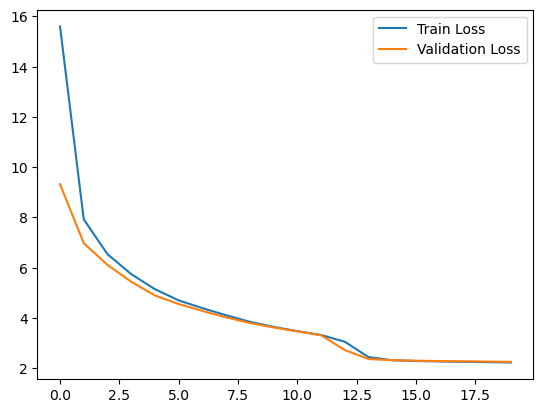

In [13]:
plt.plot(train_losses, label='Train Loss')  
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [14]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 19.61%


# 3 Layer MLP

In [15]:
class FCNet3(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(FCNet3, self).__init__()
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2 , bias = True)
        self.fc3 = nn.Linear(hidden_size2, output_size , bias = True)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = FCNet3(Xtr.shape[1], 1024, 64 , len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6) 

Epoch 1/10, Train Loss: 4.5089, Val Loss: 2.9652
Epoch 2/10, Train Loss: 2.5377, Val Loss: 2.2814
Epoch 3/10, Train Loss: 2.2455, Val Loss: 2.2191
Epoch 4/10, Train Loss: 2.1905, Val Loss: 2.1771
Epoch 5/10, Train Loss: 2.1427, Val Loss: 2.1376
Epoch 6/10, Train Loss: 2.0988, Val Loss: 2.1004
Epoch 7/10, Train Loss: 2.0591, Val Loss: 2.0697
Epoch 8/10, Train Loss: 2.0237, Val Loss: 2.0500
Epoch 9/10, Train Loss: 1.9926, Val Loss: 2.0404
Epoch 10/10, Train Loss: 1.9666, Val Loss: 2.0157


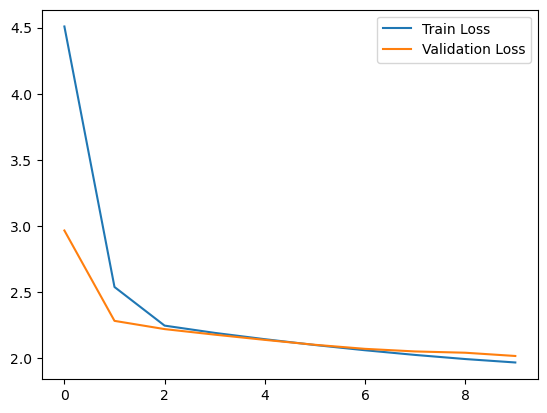

In [16]:
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/10, Train Loss: 1.9399, Val Loss: 1.9959
Epoch 2/10, Train Loss: 1.9150, Val Loss: 1.9909
Epoch 3/10, Train Loss: 1.8915, Val Loss: 1.9661
Epoch 4/10, Train Loss: 1.8698, Val Loss: 1.9455
Epoch 5/10, Train Loss: 1.8514, Val Loss: 1.9419
Epoch 6/10, Train Loss: 1.8322, Val Loss: 1.9137
Epoch 7/10, Train Loss: 1.8158, Val Loss: 1.9148
Epoch 8/10, Train Loss: 1.7996, Val Loss: 1.9099
Epoch 9/10, Train Loss: 1.7830, Val Loss: 1.8892
Epoch 10/10, Train Loss: 1.7690, Val Loss: 1.8787


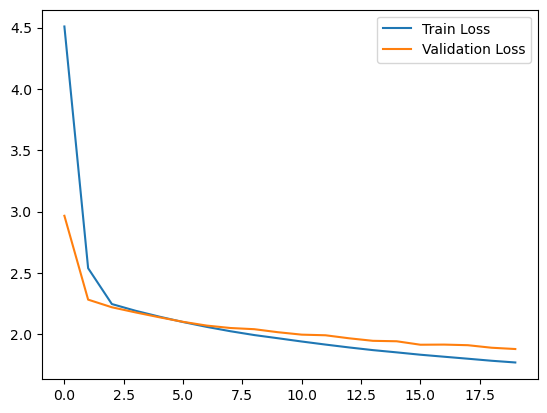

In [17]:
epochs = 10
for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [18]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet3(
  (relu1): ReLU()
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=1024, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Test Accuracy: 37.63%


## 3 Layer MLP with Batch Normalization

In [19]:
class FCNet3_BN(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(FCNet3_BN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2 , bias = True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size , bias = True)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = FCNet3_BN(Xtr.shape[1], 1024, 128 , len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6) 

Epoch 1/20, Train Loss: 2.1721, Val Loss: 2.0403
Epoch 2/20, Train Loss: 1.9871, Val Loss: 1.9372
Epoch 3/20, Train Loss: 1.9038, Val Loss: 1.8804
Epoch 4/20, Train Loss: 1.8513, Val Loss: 1.8414
Epoch 5/20, Train Loss: 1.8118, Val Loss: 1.8131
Epoch 6/20, Train Loss: 1.7821, Val Loss: 1.7861
Epoch 7/20, Train Loss: 1.7559, Val Loss: 1.7634
Epoch 8/20, Train Loss: 1.7344, Val Loss: 1.7458
Epoch 9/20, Train Loss: 1.7160, Val Loss: 1.7311
Epoch 10/20, Train Loss: 1.6987, Val Loss: 1.7165
Epoch 11/20, Train Loss: 1.6815, Val Loss: 1.7075
Epoch 12/20, Train Loss: 1.6669, Val Loss: 1.6886
Epoch 13/20, Train Loss: 1.6548, Val Loss: 1.6829
Epoch 14/20, Train Loss: 1.6416, Val Loss: 1.6741
Epoch 15/20, Train Loss: 1.6298, Val Loss: 1.6628
Epoch 16/20, Train Loss: 1.6174, Val Loss: 1.6574
Epoch 17/20, Train Loss: 1.6059, Val Loss: 1.6463
Epoch 18/20, Train Loss: 1.5960, Val Loss: 1.6386
Epoch 19/20, Train Loss: 1.5869, Val Loss: 1.6318
Epoch 20/20, Train Loss: 1.5764, Val Loss: 1.6233


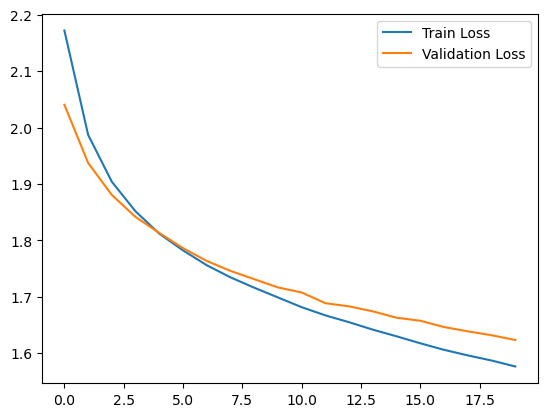

In [20]:
epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [21]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet3_BN(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 46.78%


## 3 Layer MLP with Batch Normalization and Dropout

In [22]:
class FCNet3_BN_DO(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(FCNet3_BN_DO, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1, bias=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2 , bias = True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(hidden_size2, output_size , bias = True)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model = FCNet3_BN_DO(Xtr.shape[1], 1024, 128 , len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6) 

Epoch 1/10, Train Loss: 2.2385, Val Loss: 2.0863
Epoch 2/10, Train Loss: 2.0678, Val Loss: 1.9897
Epoch 3/10, Train Loss: 1.9856, Val Loss: 1.9343
Epoch 4/10, Train Loss: 1.9369, Val Loss: 1.8933
Epoch 5/10, Train Loss: 1.8986, Val Loss: 1.8616
Epoch 6/10, Train Loss: 1.8662, Val Loss: 1.8394
Epoch 7/10, Train Loss: 1.8430, Val Loss: 1.8181
Epoch 8/10, Train Loss: 1.8220, Val Loss: 1.8035
Epoch 9/10, Train Loss: 1.8015, Val Loss: 1.7891
Epoch 10/10, Train Loss: 1.7830, Val Loss: 1.7757


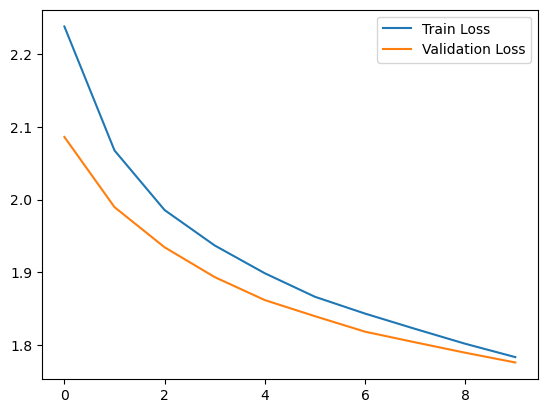

In [23]:
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

Epoch 1/10, Train Loss: 1.7707, Val Loss: 1.7593
Epoch 2/10, Train Loss: 1.7541, Val Loss: 1.7499
Epoch 3/10, Train Loss: 1.7441, Val Loss: 1.7357
Epoch 4/10, Train Loss: 1.7311, Val Loss: 1.7303
Epoch 5/10, Train Loss: 1.7166, Val Loss: 1.7204
Epoch 6/10, Train Loss: 1.7077, Val Loss: 1.7112
Epoch 7/10, Train Loss: 1.6960, Val Loss: 1.6982
Epoch 8/10, Train Loss: 1.6898, Val Loss: 1.6920
Epoch 9/10, Train Loss: 1.6815, Val Loss: 1.6825
Epoch 10/10, Train Loss: 1.6712, Val Loss: 1.6795


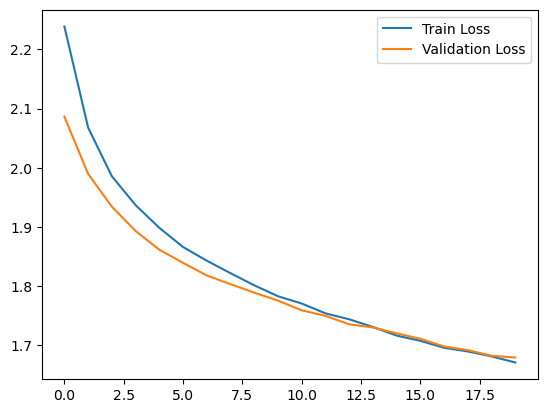

In [24]:
epochs = 10
for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [25]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet3_BN_DO(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 44.90%


# Best Model : 3 Layer MLP with Batch Normalization
## training for long

Epoch 1/100, Train Loss: 2.1599, Val Loss: 2.0435
Epoch 11/100, Train Loss: 1.6864, Val Loss: 1.7120
Epoch 21/100, Train Loss: 1.5700, Val Loss: 1.6209
Epoch 31/100, Train Loss: 1.4880, Val Loss: 1.5696
Epoch 41/100, Train Loss: 1.4235, Val Loss: 1.5244
Epoch 51/100, Train Loss: 1.3661, Val Loss: 1.4860
Epoch 61/100, Train Loss: 1.3154, Val Loss: 1.4582
Epoch 71/100, Train Loss: 1.2682, Val Loss: 1.4328
Epoch 81/100, Train Loss: 1.2211, Val Loss: 1.4181
Epoch 91/100, Train Loss: 1.1774, Val Loss: 1.3959


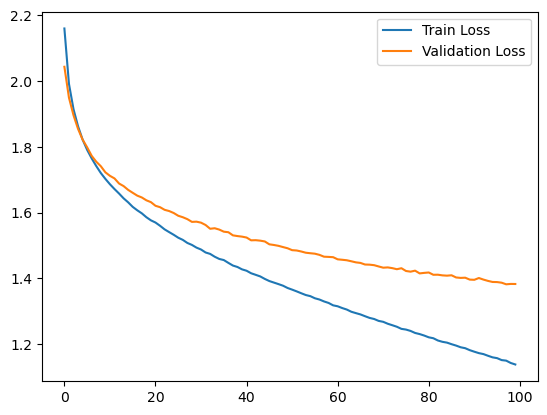

FCNet3_BN(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 52.79%


In [26]:
model = FCNet3_BN(Xtr.shape[1], 1024, 128 , len(labels))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-6) 

epochs = 100
train_losses = []
val_losses = []

saved_models = []

for epoch in range(epochs):
    _ = model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    # Validation
    _ = model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    
    if epoch % (epochs//4) == 0:
        saved_models.append(model.state_dict())
        
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [27]:
model.eval()
total, correct = 0, 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

FCNet3_BN(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Test Accuracy: 52.79%


In [28]:
def ensemble_predict(models, data_loader):
    preds = []
    loaded_models = []
    for mod in models :
        model = FCNet3_BN(Xtr.shape[1], 1024, 128 , len(labels))
        model.load_state_dict(mod) 
        model.eval()
        loaded_models.append(model)
    actuals = []
    for batch in data_loader:
        inputs, outs = batch
        actuals.append(outs)
        outputs = torch.zeros(inputs.shape[0], len(labels))
        for model in loaded_models:
            outputs += model(inputs)
        preds.append(outputs) 

    accuracy = 0 
    for i in range(len(preds)):
        accuracy += torch.sum(preds[i].argmax(dim = 1) == actuals[i])
    return accuracy / len(data_loader.dataset) , torch.cat(preds), torch.cat(actuals)

ensemble_accuracy, preds, actuals = ensemble_predict(saved_models, test_loader)

preds.shape, actuals.shape
print(f"Ensemble Accuracy: {ensemble_accuracy * 100:.2f}%")

(torch.Size([10000, 10]), torch.Size([10000]))

Ensemble Accuracy: 52.79%
